## 製品価格予測

（講師は A100 を使用しているが T4 でも実行可能）

### そして今、ファインチューニングされたOSSモデルを評価


In [1]:
# pip install

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# import

import os
import re
import math
from datetime import datetime
from tqdm import tqdm

from google.colab import userdata
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict

import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from peft import PeftModel

import matplotlib.pyplot as plt

In [3]:
# 定数

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "lite-pricer"
HF_USER = "nishi74322014"

# 実行自体

RUN_NAME = "2025-08-08_23.34.01"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
REVISION = "" # "e8d637df551603dc86cd7a1598a8f44af4d7ae36"
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

# データ

DATASET_NAME = f"{HF_USER}/lite-data"

# QLoRAのハイパーパラメーター

QUANT_4_BIT = True

%matplotlib inline

# 色の出力に書き込みに使用されます

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

### Hugging Face にログインします

まだHugging Faceアカウントをお持ちでない場合は、https://huggingface.co にアクセスしてサインアップしてトークンを作成します。

次に、左のキーアイコンをクリックして、このノートブックのシークレットを選択し、トークンとして値を持つ `HF_TOKEN` と呼ばれる新しい秘密を追加します。

In [4]:
# Hugging Face Hub にプログラムからログイン
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

# データをロード

Hugging Faceにアップロードしたので、取得するのは簡単

In [5]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/9.84M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/780k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color\n\nPrice is $",
 'price': 65.99}

## 次に、トークナイザとモデルをロード

モデルを「量子化」し、精度を4ビットに減らす。

In [7]:
# 適切な量子化を選択します（8ビットバージョンでバグを見つけてくれたRobert M.に感謝します！）

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [8]:
# トークナイザとモデルをロード

# トークナイザをロード
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# （ベース）モデルをロード
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)

# （バッチ化などで）長さを揃えるために 「pad_token_id」 が必要
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# ファインチューニングされたPEFTモデルをロード
if REVISION:
  # 指定されたコミットやタグ（バージョン）からモデルを読み込み
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  # デフォルトブランチの最新コミットからモデルを読み込み
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

Memory footprint: 5700.6 MB


In [9]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

# 真実の瞬間！

## 推論モードでモデルを使用

- GPT-4oの平均誤差は\$ 76でした。  
- Llama 3.1ベースモデルの平均誤差は\$ 396でした。   
- この人間には\$ 127の誤りがありました。  

## 警告

- 商品の価格はかなり異なることに注意してください。
- モデルは、情報がない販売価格のようなものを予測することはできません。

In [10]:
# 文字列から価格を抽出する関数

def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [11]:
# 価格抽出関数をテストする
extract_price("Price is $a fabulous 899.99 or so")

899.99

In [12]:
# itemのプロンプトからファインチューニングされたモデルが推定した値を返す

def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [13]:
# itemのプロンプトからファインチューニングされたモデルが推定した上位3つの加重平均を返す
# （Llamaが3桁までの数字につき、1トークンを生成しない場合、より複雑になる）

top_K = 3 # 上位3個のトークンを処理対象とする

def improved_model_predict(prompt, device="cuda"):
    # ランダム性の再現性確保
    set_seed(42)
    # プロンプト文字列をトークンに変換
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    # 全トークンを活性化したマスク
    attention_mask = torch.ones(inputs.shape, device=device)

    # 以降が異なる
    # このコードは「次の1トークン」の予測確率分布：スコア（ロジット）を推論する処理

    with torch.no_grad(): # 勾配計算を無効化して推論専用にする。

        # モデルに入力トークン列 inputs と attention_maskを与えて順伝播する。
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)

        # LLMの場合、outputs.logits は通常 [batch_size, seq_len, vocab_size]
        next_token_logits = outputs.logits[:, -1, :].to('cpu')
        # ・各バッチについて「最後のトークン位置（-1）」のスコアだけを取り出す。
        # ・形状は [batch_size, vocab_size]で「次に出力しうる各語彙トークンのスコア」を表す。
        # ・後で numpy() にしたりCPU側で後処理するため、.to('cpu') でテンソルをCPUに移す。

    # 次トークン生成での Top-K 手法の前処理
    # ロジット next_token_logits を softmax で確率分布に変換
    # dim=-1：最後の次元（vocab_sizeの次元）に沿ってsoftmaxで
    # 正規化しバッチごと合計が 1 になる確率ベクトルを得る。
    next_token_probs = F.softmax(next_token_logits, dim=-1)
    # 上位K個の top_token_id 候補トークンID、top_prob 確率
    top_prob, top_token_id = next_token_probs.topk(top_K)

    # 候補トークンIDのうち、“正の数”と解釈できるもの抽出し、数値・確率を収集
    prices, weights = [], [] # 数値・確率
    for i in range(top_K): # 上位K個の候補についてループ
      # トークンIDを文字列にデコード
      predicted_token = tokenizer.decode(top_token_id[0][i])
      # 対応する確率（もしくはスコア）を取り出し
      probability = top_prob[0][i]

      # 文字列が数値として解釈
      try:
        # ...できれば float に変換
        result = float(predicted_token)
      except ValueError as e:
        # ...できなければ 0.0 に変換
        result = 0.0

      # 正の数だけを有効とみなし追加
      if result > 0:
        prices.append(result)
        weights.append(probability)

    # 空の場合
    if not prices:
      return 0.0, 0.0

    # 重みの合計で正規化し、確率による加重平均を計算
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]

    # 最終的に float 型の値として返却
    return sum(weighted_prices).item()

In [14]:
# testing.py の Tester と差はほぼなし。
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $25.00 Truth: $65.99 Error: $40.99 SLE: 0.90 Item: Setpower Insulated P...
2: Guess: $7.00 Truth: $9.68 Error: $2.68 SLE: 0.08 Item: TUAIC Refrigerator D...
3: Guess: $220.00 Truth: $155.98 Error: $64.02 SLE: 0.12 Item: Kegco Secondary Regu...
4: Guess: $7.00 Truth: $5.59 Error: $1.41 SLE: 0.04 Item: Refrigerator Door Sp...
5: Guess: $54.00 Truth: $98.40 Error: $44.40 SLE: 0.35 Item: Ice-O-Matic Float Va...
6: Guess: $25.00 Truth: $54.99 Error: $29.99 SLE: 0.59 Item: Wireless Temperature...
7: Guess: $7.00 Truth: $5.71 Error: $1.29 SLE: 0.03 Item: 3Inch Thermometer Hy...
8: Guess: $19.00 Truth: $9.53 Error: $9.47 SLE: 0.41 Item: GE GE Timer Knob Ass...
9: Guess: $15.00 Truth: $11.24 Error: $3.76 SLE: 0.07 Item: newlifeapp Dryer Lin...
10: Guess: $19.00 Truth: $12.88 Error: $6.12 SLE: 0.13 Item: Away NV350 NV351 NV3...
11: Guess: $110.00 Truth: $99.99 Error: $10.01 SLE: 0.01 Item: Refrigerator Ice Mak...
12: Guess: $19.00 Truth: $16.99 Error: $2.01 SLE: 0.01 Item: 2 PACKS Wate

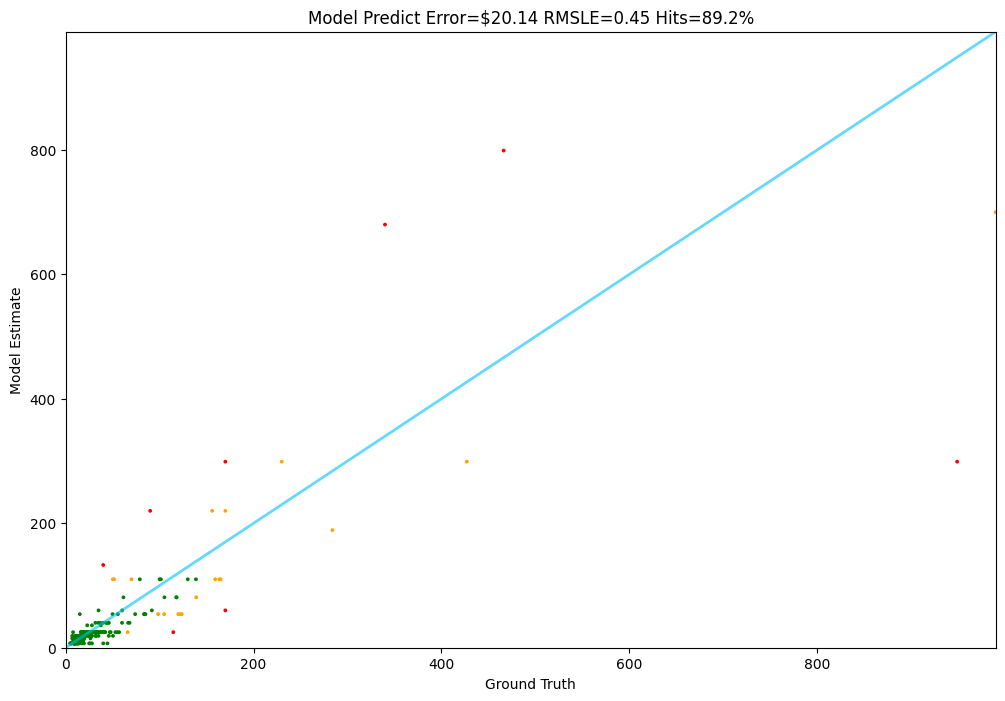

In [15]:
# TestRunnerを実行
Tester.test(model_predict, test)

1: Guess: $31.45 Truth: $65.99 Error: $34.54 SLE: 0.53 Item: Setpower Insulated P...
2: Guess: $8.93 Truth: $9.68 Error: $0.75 SLE: 0.01 Item: TUAIC Refrigerator D...
3: Guess: $196.38 Truth: $155.98 Error: $40.40 SLE: 0.05 Item: Kegco Secondary Regu...
4: Guess: $9.05 Truth: $5.59 Error: $3.46 SLE: 0.18 Item: Refrigerator Door Sp...
5: Guess: $58.12 Truth: $98.40 Error: $40.28 SLE: 0.27 Item: Ice-O-Matic Float Va...
6: Guess: $30.84 Truth: $54.99 Error: $24.15 SLE: 0.32 Item: Wireless Temperature...
7: Guess: $7.96 Truth: $5.71 Error: $2.25 SLE: 0.08 Item: 3Inch Thermometer Hy...
8: Guess: $11.73 Truth: $9.53 Error: $2.20 SLE: 0.04 Item: GE GE Timer Knob Ass...
9: Guess: $12.22 Truth: $11.24 Error: $0.98 SLE: 0.01 Item: newlifeapp Dryer Lin...
10: Guess: $18.81 Truth: $12.88 Error: $5.93 SLE: 0.13 Item: Away NV350 NV351 NV3...
11: Guess: $100.62 Truth: $99.99 Error: $0.64 SLE: 0.00 Item: Refrigerator Ice Mak...
12: Guess: $17.12 Truth: $16.99 Error: $0.14 SLE: 0.00 Item: 2 PACKS Water

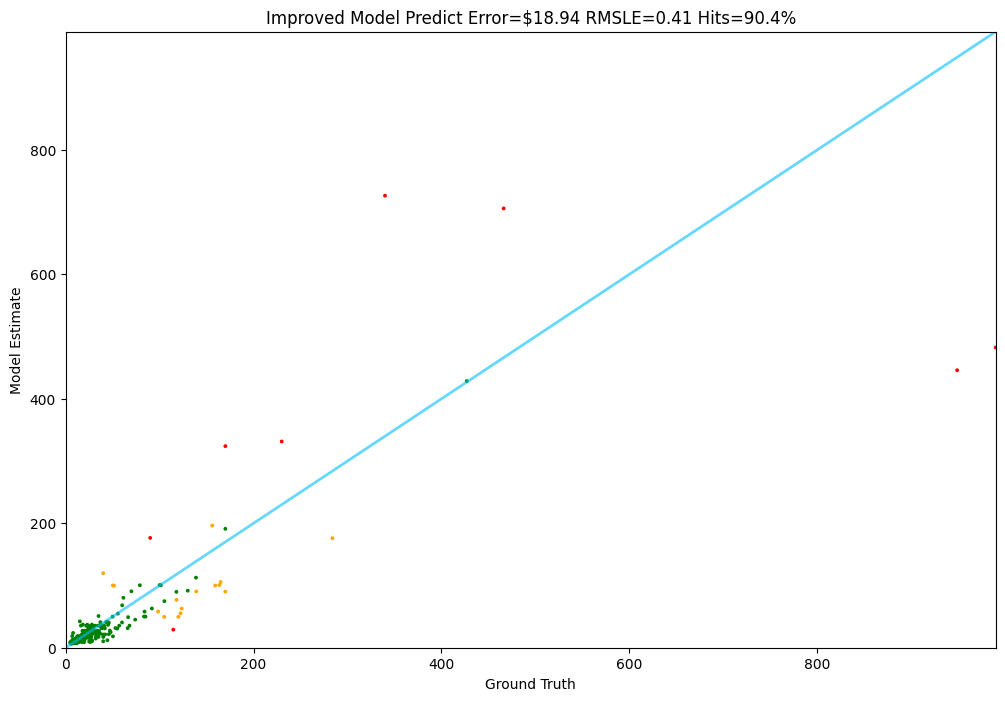

In [16]:
# TestRunnerを実行
Tester.test(improved_model_predict, test)